# Example 1.1: What is random vibrations?
In this example, we will discuss how stochastic vibrations differ from deterministic vibrations. The stochastic behaviour of a linear dynamic system originates from the uncertainty of the dynamic loads. If we do not know the loads, we do not know the response either. 

This situation is not different from what we are used to from static analysis since we rarely know the static loads precisely. Instead, we use what we know about the statistical properties of the static loads to determine design loads with a selected annual probability of exceedance. This approach is possible since the largest static loads will give the largest static response and associated load effect.  

We use a similar approach when designing structures subjected to uncertain dynamic loads. Still, since the response depends on the instantaneous load and the load history, we need to use an approach where the load history and, thus, dynamic magnification are considered.

This example considers a simple two-degree-of-freedom system subjected to deterministic (known) and stochastic (uncertain) loads. It illustrates the difference between stochastic and deterministic dynamic loads and vibrations.

## Shear frame

The shear frame has a mass $m=1$ kg and stiffness $N=100$ N/m. 

<center>
<img src="figures\shearframe.svg">
</center>



## Define structural properties
We start by defining the structural properties of a two-degree of freedom dynamic system

$$ \mathbf{M} \ddot{\mathbf{y}} + \mathbf{C} \dot{\mathbf{y}} + \mathbf{K} \mathbf{y} = \mathbf{X}(t) $$

In [1]:
# Import necessary packages and modules
import numpy as np
from scipy import linalg as spla
import sys
sys.path.append('./../modules')
from time_integration import * # Import all functions in the module time_integration
from matplotlib import pyplot as plt 

# Define structural properties
m = 1.0 # Mass of each story
k = 100.0 # Stiffness
MM = np.eye(2)*m # Mass matrix
KK = np.array(([[2, -1], [-1, 1]]))*k # Stiffness matrix

we then calculate the natural frequencies and mode shapes by solving the generalized eigenvalue problem.

$$ \left( \mathbf{K} - \lambda \mathbf{M} \right) \Phi = \mathbf{0} $$

In [2]:
# Calculate modes and frequencies
lam,v = spla.eig(KK,MM) #Solve eigenvalue problem using scipy 
#lam = np.reshape(lam, (1, lam.shape[0]))
v[:,0] = v[:,0]/np.max(v[:,0]) #Normalize the eigenvector
v[:,1] = v[:,1]/np.max(v[:,1])
f = np.real(lam)**0.5/2/np.pi #Natural frequencies in Hz
omega = f*2*np.pi # Natural frequencies in rad/s

print(omega)
print(v)

[16.18033989  6.18033989]
[[ 1.          0.61803399]
 [-0.61803399  1.        ]]


We assume thet the damping can be modelled using Rayleigh damping and assign 5% damping for the two vibration modes. Since we only have two degrees of freedom this means that we get the two damping ratios that we assign for the two modes. Rayleigh damping is defined as

$$ \mathbf{C} = \alpha_1 \mathbf{M} + \alpha_2 \mathbf{K} $$

The factors $\alpha_1$ and $\alpha_2$ are defined as

$$ \alpha_{1} = 2 \omega_{1}\omega_2 \frac{\left(\zeta_2\omega_{1}-\zeta_{1}\omega_2 \right)} {\omega_{1}^2-\omega_2^2} $$

$$ \alpha_2 = 2 \frac{\zeta_1 \omega_1 -\zeta_2\omega_2}{\omega_1^2-\omega_2^2}    $$


In [3]:
# Rayleigh damping
zeta = np.array(([5.0, 5.0]))/100
alpha1 = 2*omega[0]*omega[1]*(zeta[1]*omega[0]-zeta[0]*omega[1])/(omega[0]**2-omega[1]**2)
alpha2 = 2*(zeta[0]*omega[0]-zeta[1]*omega[1])/(omega[0]**2-omega[1]**2)
CC = alpha1*MM + alpha2*KK

print(alpha1)
print(alpha2)


0.4472135954999579
0.004472135954999579


## Dynamic response due to deterministic harmonic loads
We then calculate the response of the two degree of freedom system subjected to a harmonic load. We solve the dynamic response using Newmark time integration.

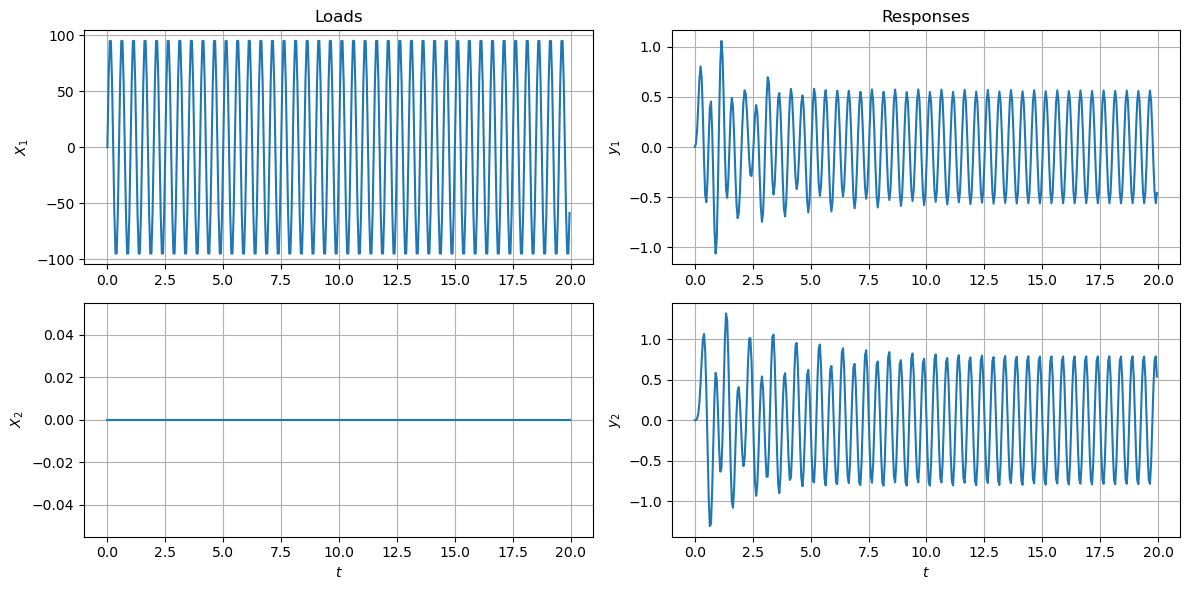

In [4]:
h = 0.05 #Time step
t = np.arange(0.,20.,h) # Time vector
f = 2.0 # Load frequency in Hz
p0 = 100.0 # Load amplitude
u0 = np.array([[0.0], [0.0]]) #Initial displacement
udot0 = np.array([[0.0], [0.0]]) # Initial velocity

beta = 1.0/4.0 # Facor in Newmark's method
gamma = 1.0/2.0 # Factor in Newmark's method

X = p0*np.vstack((np.sin(2.0*np.pi*f*t),np.zeros_like(t)))

y, ydot, y2dot = linear_newmark_krenk(MM,CC,KK,X,u0,udot0,h,gamma,beta)

# Plot deterministic dynamic load and response
fig, axs = plt.subplots(2,2,figsize=(12,6))
axs[0,0].plot(t, X[0,:])
axs[0,0].set_ylabel('$X_1$')
axs[0,0].set_title('Loads')
axs[0,0].grid(True)

axs[1,0].plot(t, X[1,:])
axs[1,0].set_ylabel('$X_2$')
axs[1,0].set_xlabel('$t$')
axs[1,0].grid(True)

axs[0,1].plot(t, y[0,:])
axs[0,1].set_ylabel('$y_1$')
axs[0,1].set_title('Responses')
axs[0,1].grid(True)

axs[1,1].plot(t, y[1,:])
axs[1,1].set_ylabel('$y_2$')
axs[1,1].set_xlabel('$t$')
axs[1,1].grid(True)

plt.tight_layout()

We observe that the structure starts from rest and that there is a transient response that lasts for about 10 seconds until the structure reaches a steady-state dynamic response. Since the loads are deterministic (known), the response will be perfectly the same each time we solve it.

## Dynamic response due to one stochastic load

In this section, we will study the dynamic response due to a single stochastic load $X_1$. We start by assuming the load is Gaussian distributed with zero mean value and a standard deviation of one.


28.451365972046535


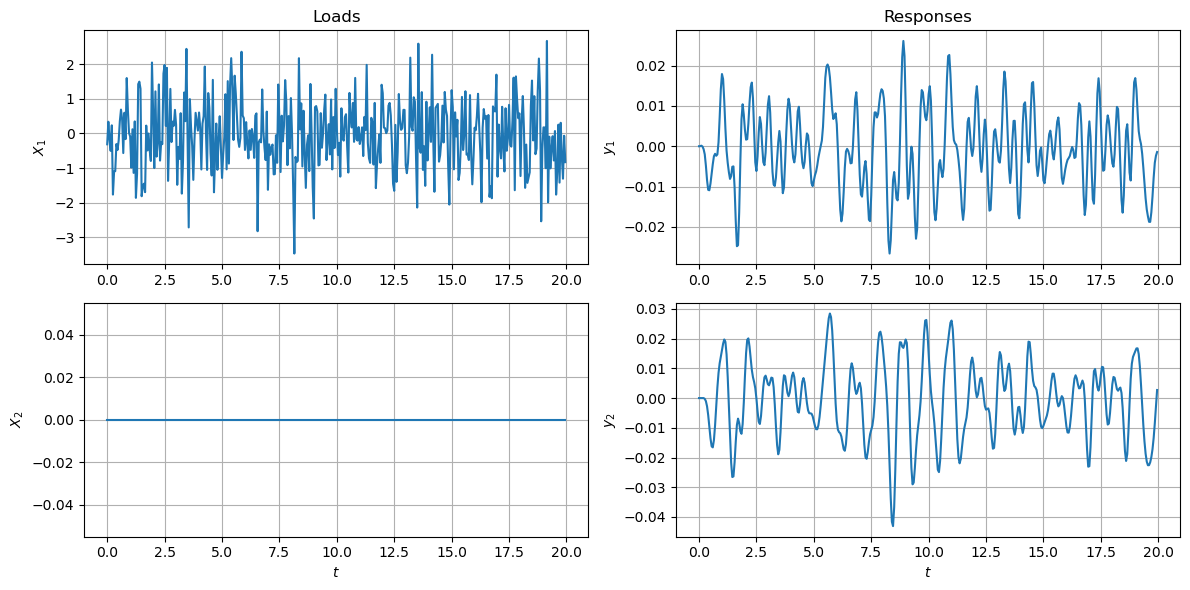

In [5]:
np.random.seed(seed=15)

X1=np.random.normal(0,1,t.shape[0])
X2=np.zeros_like(X1)

X = np.vstack((X1,X2))

y, ydot, y2dot = linear_newmark_krenk(MM,CC,KK,X,u0,udot0,h,gamma,beta)

# Plot stochastic dynamic load and response
fig, axs = plt.subplots(2,2,figsize=(12,6))
axs[0,0].plot(t, X[0,:])
axs[0,0].set_ylabel('$X_1$')
axs[0,0].set_title('Loads')
axs[0,0].grid(True)

axs[1,0].plot(t, X[1,:])
axs[1,0].set_ylabel('$X_2$')
axs[1,0].set_xlabel('$t$')
axs[1,0].grid(True)

axs[0,1].plot(t, y[0,:])
axs[0,1].set_ylabel('$y_1$')
axs[0,1].set_title('Responses')
axs[0,1].grid(True)

axs[1,1].plot(t, y[1,:])
axs[1,1].set_ylabel('$y_2$')
axs[1,1].set_xlabel('$t$')
axs[1,1].grid(True)

plt.tight_layout()

print(np.max(y[1,:]*1000))

## Dynamic response due to two stochastic loads

We now look at two stochastic loads with a correlation. We still assume that the loads are Gaussian distributed with zero mean values. Since the loads are correlated, we need to generate them as correlated Gaussian variables. The joint distribution of the loads is then defined by the vector of mean values and the covariance matrix.

$$ \mathbf{\mu}_{\bf{x}} = \left[ \begin{array}{c} \mu_{X_1} \\ \mu_{X_2} \end{array} \right] $$

and a covariance matrix $\mathbf{\Sigma^2_x}$

$$ \Sigma^2 _{\bf{x}} = \left[ \begin{array}{c c}
{\sigma _{X_1}^2}&{\rho _{X_1X_2}\sigma _{X_1}\sigma _{X_2}}\\
{\rho _{X_2X_1}\sigma _{X_2}\sigma _{X_1}}&{\sigma _{X_2}^2}
\end{array} \right] $$

Here $\sigma _{{X_1}}$ and $\sigma _{{X_1}}$ are the the standard deviations, while $\sigma^2 _{{X_1}}$ and $\sigma^2 _{{X_1}}$ are the the variance of $X_1$ and $X_2$. The correlation coefficient is denoted $\rho _{{X_1}{X_2}}$. There are functions to simulate correlated Gaussian variables in the NumPy package, but we will show how Gaussian distributed variables can be generated using only basic functions. 

The first step is to transform the variables to uncorrelated space. We define the link between correlated space $\mathbf{X}$ and the uncorrelated space $\tilde{\mathbf{X}}$  as

$$\mathbf{X} = \mathbf{V}\tilde{\mathbf{X}}  $$

$$ \tilde{\mathbf{X}}  = \mathbf{V}^\text{T} \mathbf{X} $$

The covariance matrix of $\tilde{\mathbf{X}}$ expressed in terms of the covariance matrix of $\mathbf{X}$ is defined as

$$ \mathbf{\Sigma_{\tilde{X}}}^2 = \text{E} \left[ \mathbf{V}^\text{T} \mathbf{X} \mathbf{X}^\text{T} \mathbf{V}  \right] = \mathbf{V}^\text{T} \text{E} \left[ \mathbf{X} \mathbf{X}^\text{T}   \right]\mathbf{V}$$

$$ \mathbf{\Sigma_{\tilde{X}}}^2 = \mathbf{V}^\text{T} \mathbf{\Sigma_{X}}^2 \mathbf{V}$$

It is seen that if the matrix $\mathbf{V}$ is taken as the eigenvectors of the covariance matrix $\mathbf{\sigma_{X}}^2$ the covariance matrix of $\mathbf{\sigma_{\tilde{X}}}^2$ becomes diagonal and the variables in the vector $\tilde{\mathbf{X}}$ uncorrelated.

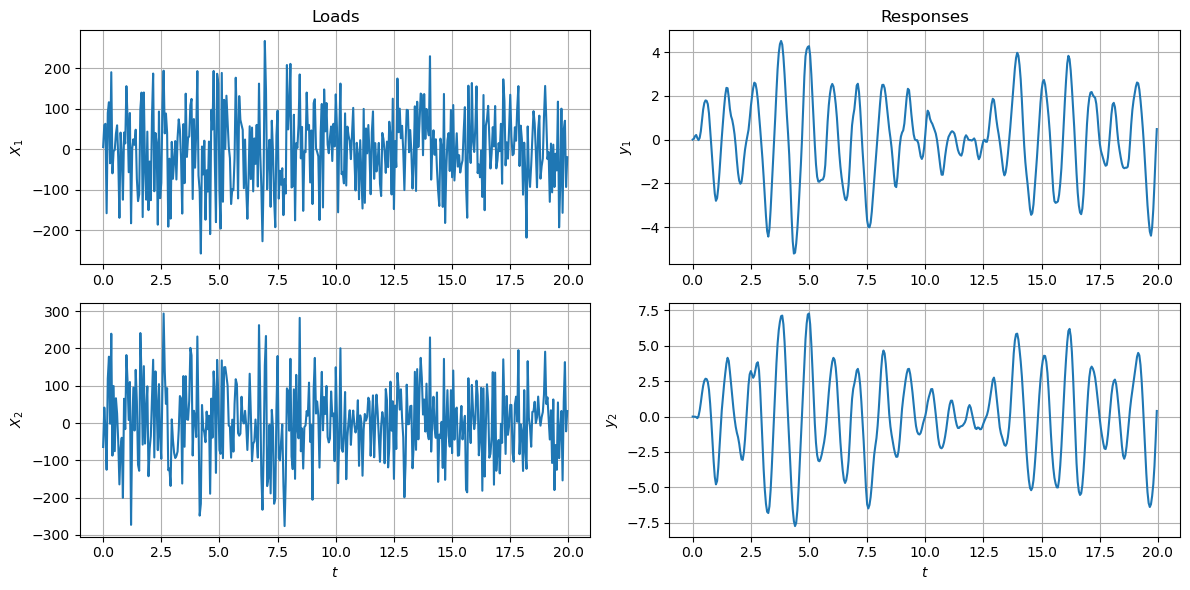

In [9]:
rho_X1_X2 = 0.8 # Load correlation coefficient
sd_X1 = 100.0 # Standard deviation X1
sd_X2 = 100.0 # Standard deviation X2

cov_X = np.array(([[sd_X1**2, rho_X1_X2*sd_X1*sd_X2], [rho_X1_X2*sd_X1*sd_X2, sd_X2**2]])) # Covariance matrix of the loads
lam,V = spla.eig(cov_X) # Solve eigenvalue problem using scipy 
cov_X_tilde = V.T @ cov_X @ V  # Transform covariance matrix to uncorrelated space

# Draw random numbers from the uncorrelated variables
X_tilde = np.vstack((np.random.normal(0, cov_X_tilde[0,0]**0.5, t.shape[0]),
                     np.random.normal(0, cov_X_tilde[1,1]**0.5, t.shape[0])))

X = V @ X_tilde # Transform back to correlated space

y, ydot, y2dot = linear_newmark_krenk(MM,CC,KK,X,u0,udot0,h,gamma,beta)

# Plot stochastic dynamic load and response
fig, axs = plt.subplots(2,2,figsize=(12,6))
axs[0,0].plot(t, X[0,:])
axs[0,0].set_ylabel('$X_1$')
axs[0,0].set_title('Loads')
axs[0,0].grid(True)

axs[1,0].plot(t, X[1,:])
axs[1,0].set_ylabel('$X_2$')
axs[1,0].set_xlabel('$t$')
axs[1,0].grid(True)


axs[0,1].plot(t, y[0,:])
axs[0,1].set_ylabel('$y_1$')
axs[0,1].set_title('Responses')
axs[0,1].grid(True)

axs[1,1].plot(t, y[1,:])
axs[1,1].set_ylabel('$y_2$')
axs[1,1].set_xlabel('$t$')
axs[1,1].grid(True)

plt.tight_layout()

The response plot shows that the stochastic dynamic response is more chaotic than the response due to harmonic excitation. The displacements are narrowly banded, which means that a narrow band of frequencies dominates the response. In this case, it is frequency content close to the natural frequencies of the structure that dominates. The dynamic loads are broadly banded since the time series has a more irregular behaviour. The load is, in fact, white noise, which implies that all frequencies are equally represented. White noise loading is obtained because the forces have been generated without any auto-correlation. Two neighbouring samples are not correlated. The dynamic response and the loads are unique because one never will get two times series that are equal. Try to execute the cell above several times and observe how the loads and the response change each time.

It is also interesting to study the correlation of the two loads and the response in degrees of freedom $y_1$ and $y_2$:

Correlation for load is 
[[1.         0.78616849]
 [0.78616849 1.        ]]
Correlation for response is 
[[1.         0.98780132]
 [0.98780132 1.        ]]


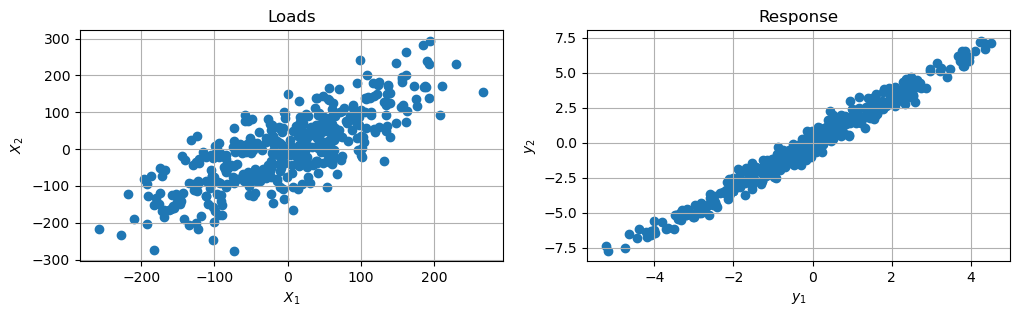

In [15]:
# Plot scatter plot of dynamic loads and response
fig, axs = plt.subplots(1,2,figsize=(12,3))
axs[0].scatter(X[0,:],X[1,:])
axs[0].set_ylabel('$X_2$')
axs[0].set_xlabel('$X_1$')
axs[0].set_title('Loads')
axs[0].grid(True)

axs[1].scatter(y[0,:],y[1,:])
axs[1].set_ylabel('$y_2$')
axs[1].set_xlabel('$y_1$')
axs[1].set_title('Response')
axs[1].grid(True)

print('Correlation for load is ')
print(np.corrcoef(X[0,:],X[1,:]))

print('Correlation for response is ')
print(np.corrcoef(y[0,:],y[1,:]))


The scatter plots above illustrate that the response correlation in degrees of freedom $y_1$ and $y_2$ i is higher than the correlation of the loads. The increased correlation occurs because the response in degree both degrees of freedom are driven by the same vibration modes. The response provided in mode 1 in degrees of freedom 1 and 2 is always perfectly correlated, and the same goes for the response in mode 2. The correlation of the total response in degrees of freedom depends on how many modes contribute to the response. We will look more in to this in future examples.